In [2]:
%%javascript
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [ ]:
# in case you don't have the packages installed already, uncomment the following

# import sys
# !{sys.executable} -m pip install numpy
# !{sys.executable} -m pip install scipy
# !{sys.executable} -m pip install matplotlib
# !{sys.executable} -m pip install astropy
# !{sys.executable} -m pip install pycbc

In [3]:
from astropy.cosmology import Planck18
from astropy import constants
import astropy.units as u
import pycbc.psd
from scipy.interpolate import interp1d
from scipy.integrate import cumtrapz
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

## Day 1

Using 
\begin{equation}
    \Omega_{GW}(f) = \frac{f}{\rho_{c,0}H_0}\int^\infty_0 dz\frac{R_V(z)}{(1+z)\sqrt{\Omega_{M,0}(1+z)^3+\Omega_{\Lambda,0}}}\frac{dE}{df}\bigg|_{f(1+z)}
\end{equation}
we compute the SGWB frequency spectrum for astrophysical SGWB models.

For CBCs, 
\begin{align}
    \frac{dE}{df} & = \frac{\pi^{2/3}G^{2/3}f^{-1/3}}{3}\int d\mathcal{M}\mathcal{M}^{5/3}P_c(\mathcal{M}) \\
    R_\star(z) & = \nu \frac{a\exp(b(z-z_m))}{a-b+b\exp(a(z-z_m))}
\end{align}

where $R_\star(z)$ is the star formation rate (SFR) with $\nu=23.9\text{yr}^{-1}\text{Gpc}^{-3}, a = 2.80, b = 2.46, z_m = 1.72$. 

To account for the time delay between binary formation and its merger time, 
\begin{equation}
    R_V(z) = \lambda\int_{t_{min}}^{t_{max}}dt_d R_\star(t(z)-t_d)P(t_d)
\end{equation}

To start with, we shall consider the SFR to be a direct proxy for the merger rate $R_V(z)$, i.e. we shall compute $\Omega_{GW}$ without timedelay considerations.

#### Define the star formation rate

In [25]:
def Rstar_z(z):
    """
    The star formation rate as a function of redshift.
    Normalized to the merger rate from GWTC-2
    https://arxiv.org/abs/2010.14533
    """
    
    a, b, zm = 2.8, 2.46, 1.72
    nu = 24. / u.yr / u.Gpc ** 3 # BBH merger rate
    return nu * a * np.exp(b * (z - zm)) / (a - b + b * np.exp(a * (z - zm)))

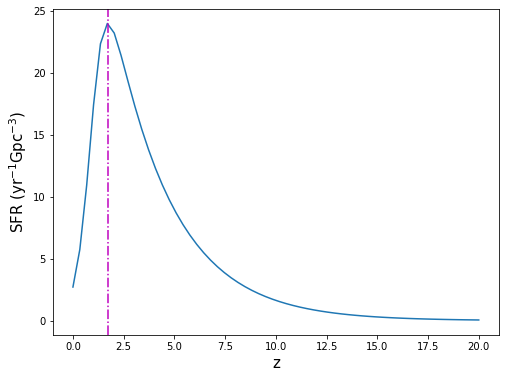

In [26]:
# plotting the SFR
plt.figure(figsize=(8,6))
z = np.linspace(0,20,60)
sfr = Rstar_z(z)
plt.plot(z,sfr)
plt.xlabel('z',size = 15)
plt.ylabel(r'SFR (yr$^{-1}$Gpc$^{-3}$)',size = 15)
plt.axvline(1.72,c='m',ls='-.')
plt.show()

#### Define dE/df

In [91]:
def dEdf(freq, factor):
    """
    Function to calculate dE/df for compact binaries.
    The factor is the integral of the chirp mass distribution
    as defined in the notes.
    """
    
    return  np.pi ** (2/3) * constants.G ** (2/3) * factor * freq ** (-1/3)/(3  * constants.c ** 2)

Text(0, 0.5, 'dE/df')

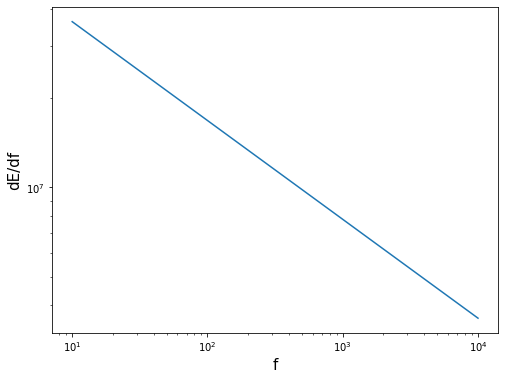

In [93]:
# Plotting dEdf for delta function
plt.figure(figsize=(8,6))
f_array = np.linspace(10,1e4)
dedf = dEdf(f_array,30 * constants.M_sun)
plt.loglog(f_array,dedf)
plt.xlabel('f',size = 15)
plt.ylabel('dE/df',size = 15)

In [ ]:
def factor_in_gaussian(mean,sigma):
    dm = 0.01
    

#### Define $\Omega_{GW}$ without considering time delay

In [29]:
def omega_GW_without_time_delay(f_arr, chirp_mass_distribution,
                               extra_args=dict()):
    """
    Function to calculate omega_gw given the chirp mass
    distribution. Also takes extra_args that go into the 
    the distribution for chirp mass.
    """
    
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    if chirp_mass_distribution == "delta_function":
        factor = extra_args["val"] ** (5/3) * u.M_sun ** (5/3)
    
    else:
        delta_chirp_mass = 0.1
        chirp_mass_arr = np.arange(0, 200, delta_chirp_mass)
        factor_integrand = chirp_mass_arr ** (5/3) * chirp_mass_distribution(chirp_mass_arr, **extra_args)
        factor = np.sum(factor_integrand) * delta_chirp_mass  * u.M_sun ** (5/3)
        print(factor)
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck18.critical_density0 * Planck18.H0) 
        integrand = Rstar_z(z) / (1 + z) * Planck18.inv_efunc(z) * dEdf(freq * (1 + z), factor) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result

#### A few distributions (for chirp mass and time delay)

In [44]:
def gaussian(x, mu, sigma):
    return 1 / np.sqrt(2 * np.pi * sigma ** 2) * np.exp(-(x - mu) ** 2  / 2 / sigma **2)

def flat(x, minimum, maximum):
    y = np.zeros_like(x)
    useful_indices = np.intersect1d(
        np.where(x > minimum), np.where(x < maximum)
    )
    y[useful_indices] = 1 / (maximum - minimum)
    return y

def inverse_x(x, minimum, maximum):
    y = np.zeros_like(x)
    useful_indices = np.intersect1d(
        np.where(x > minimum), np.where(x < maximum)
    )
    y[useful_indices] = 1 / x[useful_indices]
    y /= np.log(maximum/minimum)
    return y

#### We can now compute $\Omega_{GW}$

498it [00:01, 274.10it/s]
498it [00:01, 279.51it/s]


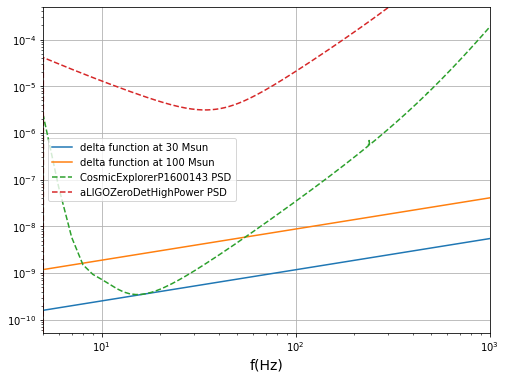

In [31]:
plt.figure(figsize=(8,6))

f_arr = np.arange(5, 1000, 2)
for chirp_mass in [30, 100]:
    omega = omega_GW_without_time_delay(f_arr, "delta_function", extra_args=dict(val=chirp_mass),)
    plt.loglog(f_arr, omega, label=f"delta function at {chirp_mass} Msun")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck18.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")
plt.legend(loc="best")
plt.ylim(ymax=5e-4)
plt.grid()
plt.xlim(5, 1000)
plt.xlabel('f(Hz)',size = 14)
plt.show()

## Day 2

Here we shall incorporate the time delay between formation and merger

In [48]:
z_arr = np.logspace(-6, np.log10(1000), 100000)
lookback_time_to_z = interp1d(Planck18.lookback_time(z_arr).to(u.Myr).value, z_arr)

def Rstar_tL(lookback_time):
    """
    The star formation rate as a function of lookback time
    """
    useful_indices = np.intersect1d(
                        np.where(lookback_time < 1.377e4),
                        np.where(lookback_time > 1),
    )
    result = np.zeros_like(lookback_time)
    result[useful_indices] = Rstar_z(lookback_time_to_z(lookback_time[useful_indices]))
    return result / u.yr / u.Gpc ** 3

In [49]:
def Rv_z(z, time_delay_distribution, time_delay_args=dict()):
    """
    Rate of sources per comoving volume considering 
    time delay between formation and merger
    """
    lookback_time = Planck18.lookback_time(z).to(u.Myr).value
    result = np.zeros_like(z) / u.yr / u.Gpc ** 3
    
    time_delay_arr = np.logspace(np.log10(1e-3), np.log10(1e4), 100000)
    for ii in range(len(z)):
        integrand = Rstar_tL(lookback_time[ii] + time_delay_arr) * time_delay_distribution(time_delay_arr,
                                                                                          **time_delay_args)
        result[ii] = np.trapz(integrand, time_delay_arr)
        
    return result

#### Define $\Omega_{GW}$ considering time delay

In [56]:
def omega_GW_with_time_delay(f_arr, chirp_mass_distribution,
                                time_delay_distribution,
                                chirp_mass_args=dict(),
                                time_delay_args=dict()
                               ):
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 10, 100)
    delta_z = z[1] - z[0]
    
    if chirp_mass_distribution == "delta_function":
        print("Using Delta Function distribution")
        factor = chirp_mass_args["val"] ** (5/3) * u.M_sun ** (5/3)
    
    else:
        delta_chirp_mass = 0.1
        chirp_mass_arr = np.arange(0, 200, delta_chirp_mass)
        factor_integrand = chirp_mass_arr ** (5/3) * chirp_mass_distribution(chirp_mass_arr, **extra_args)
        factor = np.sum(factor_integrand) * delta_chirp_mass  * u.M_sun ** (5/3)
#         print(factor)
    
    rate = Rv_z(z, time_delay_distribution, time_delay_args)
#     plt.plot(z, rate)
#     plt.grid()
#     plt.show()

    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck18.critical_density0 * Planck18.H0) 
        integrand = rate / (1 + z) * Planck18.inv_efunc(z) * dEdf(freq * (1 + z), factor) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result

#### Plotting $\Omega_{GW}$

Using Delta Function distribution


100it [00:00, 690.14it/s]


Using Delta Function distribution


100it [00:00, 699.37it/s]


(5, 1000)

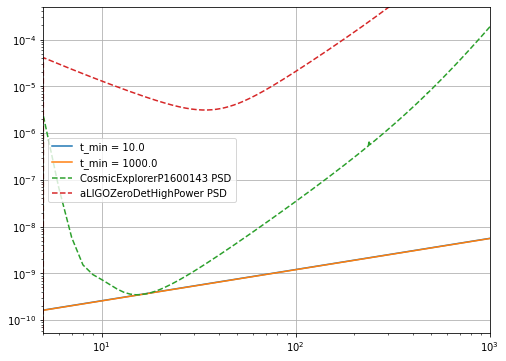

In [57]:
plt.figure(figsize=(8,6))

f_arr = np.arange(5, 1000, 10)
for tmin in [1e1, 1e3]:
    omega = omega_GW_with_time_delay(f_arr,
                                     chirp_mass_distribution="delta_function",
                                     time_delay_distribution=inverse_x,
                                     chirp_mass_args=dict(val=30),
                                    time_delay_args=dict(minimum=tmin, maximum=1e4))
    plt.loglog(f_arr, omega, label=f"t_min = {tmin}")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck18.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")
plt.legend(loc="best")
plt.ylim(ymax=5e-4)
plt.grid()
plt.xlim(5, 1000)

## Day 3

#### Calculating $\Omega_{GW}$ for the stellar collapse model

In [58]:
def Rstar_z(z):
    """
    The star formation rate as a function of redshift.
    Normalized to the merger rate from GWTC-2
    https://arxiv.org/abs/2010.14533
    """
    
    a, b, zm = 2.8, 2.46, 1.72
    nu = 0.146 * u.M_sun / u.yr / u.Mpc ** 3
    return nu * a * np.exp(b * (z - zm)) / (a - b + b * np.exp(a * (z - zm)))

In [59]:
def dEdf_stellar_core_collapse_freq_dependence(freq, a, b, xi):
    """
    Function to calculate dE/df for stellar core collapse.
    """
    freq_dependent_part =  (1 + freq / a) ** 6 * np.exp(- 2*freq/b)
    return freq_dependent_part

Text(0, 0.5, '$dE/df$')

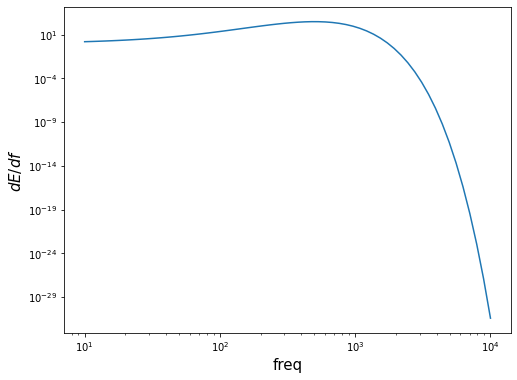

In [61]:
# Plotting the dEdf
plt.figure(figsize= (8,6))
freq_range = np.logspace(1,4,60)
dEdf = dEdf_stellar_core_collapse_freq_dependence(freq_range,100,200,1e4)
plt.loglog(freq_range,dEdf)
plt.xlabel('freq',size = 15)
plt.ylabel(r'$dE/df$',size=15)
plt.show()

In [64]:
def omega_GW_stellar_core_collapse(f_arr, dEdf_function,
                               extra_args=dict()):
    """
    Function to calculate omega_gw given the the dEdf
    distribution. Also takes extra_args that go into the 
    the distribution for chirp mass.
    """
    
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor_numerator = 8 * np.pi * constants.G * freq * extra_args["xi"]
        prefactor_denominator = 3 * Planck18.H0 ** 3 * constants.c ** 2
        integrand = Rstar_z(z) / (1 + z) * Planck18.inv_efunc(z) * dEdf_function(freq * (1 + z), **extra_args) 
        result[index] = prefactor_numerator / prefactor_denominator * np.sum(integrand) * delta_z
    return result

We then calculate $\Omega_{GW}$ and compare with the PSD scaled with the constants. Compare with Fig 1 https://arxiv.org/pdf/1701.02638.pdf


598it [00:01, 451.97it/s]
598it [00:01, 439.67it/s]
598it [00:01, 459.05it/s]
598it [00:01, 463.58it/s]


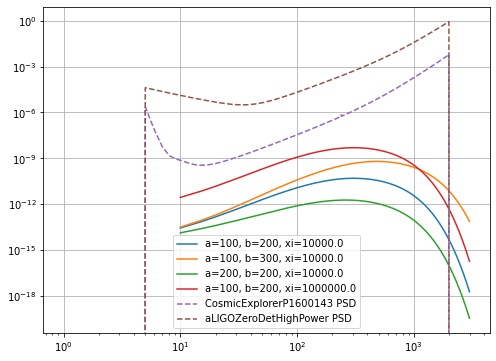

In [106]:
plt.figure(figsize=(8,6))

f_arr = np.arange(10, 3000, 5)
for params in [[100, 200, 1e4], [100, 300, 1e4], [200, 200, 1e4], [100, 200, 1e6]]:
    a, b, xi = params
    omega = omega_GW_stellar_core_collapse(f_arr, dEdf_stellar_core_collapse_freq_dependence,
                            dict(a=a * u.Hz, b=b *u.Hz, xi=xi * u.m**2/u.s))
    plt.loglog(f_arr, omega, label=f"a={a}, b={b}, xi={xi}")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck18.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")

plt.legend()
plt.grid()

#### Calculating $\Omega_{GW}$ for the magnetar model

In [96]:
def dEdf_magnetars(freq, I, R, B, eps):
    """
    Function to calculate dE/df for stellar core collapse.
    """
    term_1 = I * np.pi ** 2 * freq ** 3
    term_2 = 5 * constants.c ** 2 * R ** 6 * B ** 2 * 4 * np.pi
    term_3 = 192 * np.pi ** 2 * constants.G * I **2 * eps ** 2 * constants.mu0
    
    return term_1 / (term_2 / term_3 + freq ** 2)

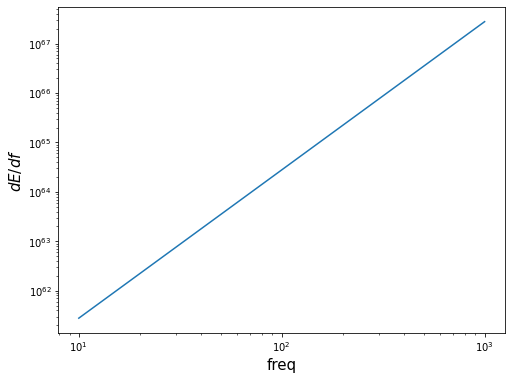

In [104]:
# Plotting the dEdf
plt.figure(figsize= (8,6))
freq_range = np.logspace(1,3,60)*u.Hz
dEdf_mag = dEdf_magnetars(freq_range,1e45*u.g * u.cm ** 2, 10* u.km, 1e15* u.gauss, 1e-5)
plt.loglog(freq_range,dEdf_mag)
plt.xlabel('freq',size = 15)
plt.ylabel(r'$dE/df$',size=15)
plt.show()

In [87]:
def omega_GW_magnetars(f_arr, lambda_frac, dEdf_function, extra_args=dict()):
    """
    Function to calculate omega_gw given the the dEdf
    distribution. Also takes extra_args that go into the 
    the dEdf function.
    """
    
    f_arr = np.asarray(f_arr) * u.Hz
    result = np.zeros_like(f_arr.value)
    z = np.linspace(0.01, 20, 10000)
    delta_z = z[1] - z[0]
    
    for index, freq in tqdm(enumerate(f_arr)):
        prefactor = freq / (Planck18.critical_density0 * Planck18.H0 * constants.c**2) 
        integrand = lambda_frac* Rstar_z(z) / (1 + z) * Planck18.inv_efunc(z) * dEdf_function(freq * (1 + z), **extra_args) 
        result[index] = prefactor * np.sum(integrand) * delta_z
    return result

598it [00:01, 369.87it/s]
598it [00:01, 315.28it/s]
598it [00:01, 352.04it/s]
598it [00:01, 323.25it/s]


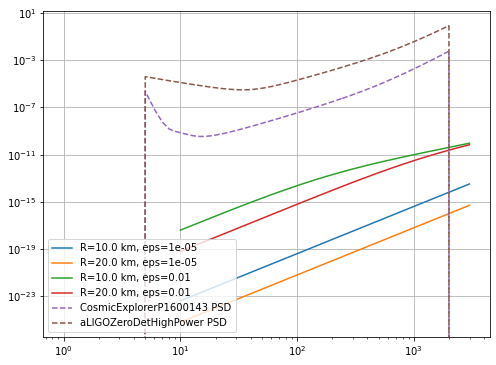

In [107]:
plt.figure(figsize=(8,6))

f_arr = np.arange(10, 3000, 5)
for params in [[1e45, 10, 1e15, 1e-5],
               [1e45, 20, 1e15, 1e-5], 
               [1e45, 10, 1e15, 1e-2],
               [1e45, 20, 1e15, 1e-2]]:
    I, R, B, eps = params
    I = I *u.g * u.cm ** 2
    R = R * u.km
    B = B * u.gauss

    omega = omega_GW_magnetars(f_arr, 1e-7 / u.M_sun, dEdf_magnetars,
                            dict(I=I, R=R, B=B, eps=eps))
    plt.loglog(f_arr, omega, label=f"R={R}, eps={eps}")

for name in ["CosmicExplorerP1600143", "aLIGOZeroDetHighPower"]:
    psd = pycbc.psd.analytical.from_string(name, 2000, 1, 5)
    psd_data = psd.data / u.Hz
    psd_frequencies = psd.sample_frequencies * u.Hz
    psd = (psd_data * (psd_frequencies) ** 3 / constants.G / Planck18.critical_density0).si * np.pi/4
    plt.plot(psd_frequencies, psd, label=name + " PSD", ls="--")

plt.legend(loc="best")
#plt.ylim(ymax=1e-10)
plt.grid()

## Day 4

We make a simulation for a simple toy model:
\begin{align}
    s_1(t) & = n_1(t) + h_1(t) \\
    s_2(t) & = n_2(t) + h_2(t) \\
    Y & = \sum_t s_1(t)s_2(t)
\end{align}

Thus, we are computing the correlation estimator in time domain with a delta function as the filter. We draw $n_i(t)$ from a zero mean, unit variance gaussian distribution. As a first step, we try $h_1(t) + h_2(t) = h =$ constant, where $h\ll 1$. We then repeat the same by letting $h$ to be a random variable drawn from a Gaussian distribution

In [111]:
import random 
import statistics
import time

In [125]:
class DistributionError(Exception):
    pass

def SNR(distribution,T_array,extra_args=dict()):
    '''
    Function to calculate SNR v/s observation time T. 
    '''
    Y_ensemble = 100 #No. of samples that we average over
    if distribution == "Constant" or distribution == 'constant':
        h = extra_args['h']
        Y_arrays = []
        
        for i in range(Y_ensemble):
            Y = []
            n1 = np.random.normal(0,1,len(T_array))
            n2 = np.random.normal(0,1,len(T_array))
            for ii in range(len(T_array)):
                if ii == 0:
                    Y.append((n1[ii] + h) * (n2[ii] + h))
                else:
                    Y.append(Y[-1] + (n1[ii] + h) * (n2[ii] + h))
            Y_arrays.append(Y)
            
    elif distribution=="Gaussian" or distribution=='gaussian':
        hmean = extra_args['hmean']
        hstdev = extra_args['hstdev']
        Y_arrays = []
        for i in range(Y_ensemble):
            Y = []
            n1 = np.random.normal(0,1,len(T_array))
            n2 = np.random.normal(0,1,len(T_array))
            ht = np.random.normal(hmean,hstdev,len(T_array))
            for ii in range(len(T_array)):
                if ii == 0:
                    Y.append((n1[ii] + ht[ii]) * (n2[ii] + ht[ii]))
                else:
                    Y.append(Y[-1] + (n1[ii] + ht[ii]) * (n2[ii] + ht[ii]))
            Y_arrays.append(Y)
    else:
        raise DistributionError("Distribution not recognized")
        
    Y_arrays = np.array(Y_arrays)        
    Average_Y = Y_arrays.mean(axis=0)
    stdev_Y = Y_arrays.std(axis=0)
    SNR = Average_Y/stdev_Y   
    return SNR

In [126]:
start = time.time()
T_array = np.linspace(0,100000,100000)
SNR_const_h = SNR('Constant',T_array, extra_args = dict(h = 0.1),)
end = time.time()
print('Computation time = ', end-start)

Computation time =  9.066108703613281


In [129]:
start = time.time()
SNR_gaussian_h = SNR('Gaussian',T_array,extra_args = dict(hmean = 0,hstdev = .1),)
end = time.time()
print('Computation time = ', end-start)

Computation time =  10.061695337295532


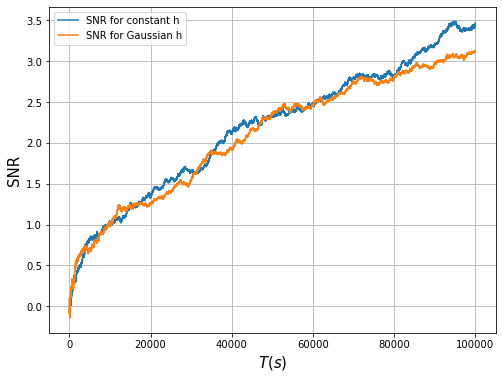

In [130]:
# Plotting the SNR
plt.figure(figsize = (8,6))
plt.plot(T_array,SNR_const_h,label = 'SNR for constant h')
plt.plot(T_array,SNR_gaussian_h,label = 'SNR for Gaussian h')
plt.xlabel(r'$T(s)$',size = 15)
plt.ylabel('SNR', size = 15)
plt.legend(loc='best')
plt.grid()